In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import torch
import yaml
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm

2024-02-24 21:26:01.604483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 21:26:01.604565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 21:26:01.606346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
folder_path = r'/kaggle/input/298b-data/298B_Data'
target_size = (200, 200)  # Target size for images

images = []
labels = []
label_counts = {}
label_encoder = LabelEncoder()  # Initialize LabelEncoder

for label in os.listdir(folder_path):
    label_folder = os.path.join(folder_path, label)
    num_images = len(os.listdir(label_folder))
    label_counts[label] = num_images
    for image_name in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        images.append(image)
        labels.append(label)

images = np.array(images)

# Encode labels
label_encoder.fit(labels)
labels_encoded = label_encoder.transform(labels)

In [3]:
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: Swine_Pox, Number of Images: 21
Label: Greasy_Pig_Disease, Number of Images: 26
Label: African_Swine_Fever, Number of Images: 11
Label: Dry_Skin, Number of Images: 4
Label: Erysipelas, Number of Images: 40
Label: Swine_Vesicular_Disease, Number of Images: 16
Label: Hog_Cholera, Number of Images: 22
Label: Pityriasis_Rosea, Number of Images: 18
Label: Mastitis, Number of Images: 20
Label: Sarcoptic_Mange, Number of Images: 24
Label: Foot_and_Mouth_Disease, Number of Images: 15
Label: Ringworm, Number of Images: 25
Label: PDNS, Number of Images: 17


In [4]:
# Get the encoded labels for each label class
encoded_labels_dict = {}
for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    encoded_labels_dict[label] = encoded_label

# Print the encoded labels for each label class
for label, encoded_label in encoded_labels_dict.items():
    print(f"Label: {label}, Encoded Label: {encoded_label}")

Label: African_Swine_Fever, Encoded Label: 0
Label: Dry_Skin, Encoded Label: 1
Label: Erysipelas, Encoded Label: 2
Label: Foot_and_Mouth_Disease, Encoded Label: 3
Label: Greasy_Pig_Disease, Encoded Label: 4
Label: Hog_Cholera, Encoded Label: 5
Label: Mastitis, Encoded Label: 6
Label: PDNS, Encoded Label: 7
Label: Pityriasis_Rosea, Encoded Label: 8
Label: Ringworm, Encoded Label: 9
Label: Sarcoptic_Mange, Encoded Label: 10
Label: Swine_Pox, Encoded Label: 11
Label: Swine_Vesicular_Disease, Encoded Label: 12


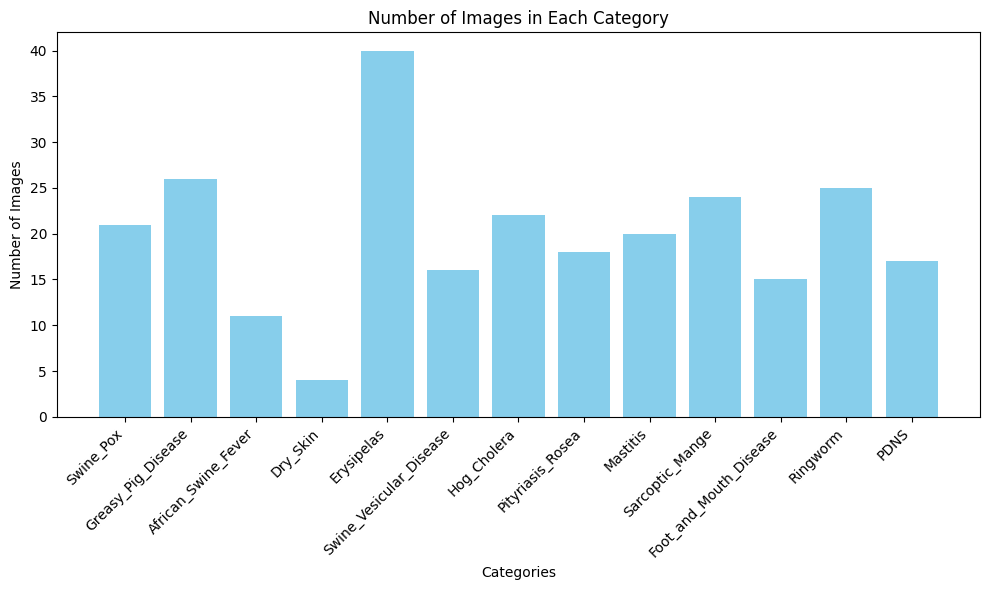

In [5]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

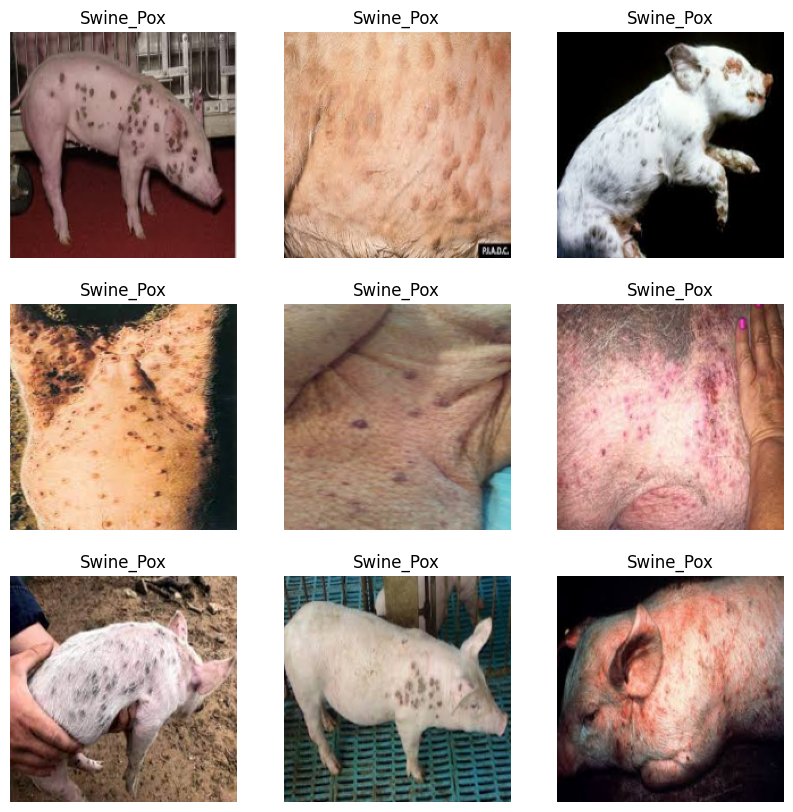

In [6]:
# Visualize cropped images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [7]:
# Step 2: Extract Features using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)
preprocessed_images = preprocess_input(images)
features = model.predict(preprocessed_images)
print("Features shape:", features.shape)  # Print the shape of features
print("Features:", features)  # Print the features themselves

9/9 [==============================] - 12s 1s/step
Features shape: (259, 2048)
Features: [[1.1894464  0.3291912  0.21440992 ... 0.         0.         1.1889827 ]
 [0.29601207 0.4972166  0.11900268 ... 0.5197008  0.5915469  2.1288939 ]
 [0.2764414  0.3233765  0.         ... 0.29119527 0.         0.3449436 ]
 ...
 [0.45669845 0.64605165 0.04682127 ... 0.4176331  1.5257429  2.1295674 ]
 [0.8184195  0.19164377 0.16886443 ... 0.         1.8632078  1.1849871 ]
 [0.01144672 0.53615695 0.89424765 ... 0.13823695 0.02472347 2.7055225 ]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
num_classes = len(np.unique(labels_encoded))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
y_test

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 

In [10]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (207, 2048)
Shape of X_test: (52, 2048)


In [11]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [12]:
# Define MobileNet model for classification
model = Sequential([
    Dense(256, activation='relu', input_shape=(features.shape[1],)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
7/7 [==============================] - 1s 51ms/step - loss: 3.5494 - accuracy: 0.1691 - val_loss: 2.7889 - val_accuracy: 0.1346
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 1.8405 - accuracy: 0.3865 - val_loss: 2.2942 - val_accuracy: 0.2115
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 1.1416 - accuracy: 0.6618 - val_loss: 2.1301 - val_accuracy: 0.3846
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: 0.6673 - accuracy: 0.8357 - val_loss: 2.2508 - val_accuracy: 0.3654
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 0.4698 - accuracy: 0.8647 - val_loss: 2.1339 - val_accuracy: 0.4038
Epoch 6/10
7/7 [==============================] - 0s 11ms/step - loss: 0.3273 - accuracy: 0.9324 - val_loss: 2.2307 - val_accuracy: 0.3654
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 0.1974 - accuracy: 0.9662 - val_loss: 2.4177 - val_accuracy: 0.3654
Epoch 8/10
7/7 [===========